In [18]:
import cudf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import asyncio

In [3]:
mu = 100 # Billion
days = 365
def gen_data(mean, std_dev, count):
    return np.abs(np.random.normal(mean, std_dev, count))

In [4]:
rows = np.round(gen_data(mu, 50, days), 0)*1e9
rows[:50]

array([2.12e+11, 1.34e+11, 1.17e+11, 1.49e+11, 1.78e+11, 3.80e+10,
       1.36e+11, 1.00e+11, 4.10e+10, 1.32e+11, 1.05e+11, 1.78e+11,
       1.14e+11, 4.40e+10, 6.90e+10, 1.05e+11, 3.30e+10, 1.19e+11,
       5.80e+10, 6.00e+09, 1.43e+11, 1.31e+11, 7.50e+10, 4.20e+10,
       6.80e+10, 1.67e+11, 1.03e+11, 8.40e+10, 1.07e+11, 7.40e+10,
       1.92e+11, 1.12e+11, 1.02e+11, 6.90e+10, 7.70e+10, 1.36e+11,
       1.16e+11, 1.21e+11, 1.34e+11, 1.25e+11, 1.03e+11, 1.70e+11,
       1.91e+11, 1.23e+11, 1.50e+11, 3.40e+10, 1.31e+11, 1.86e+11,
       6.10e+10, 1.58e+11])

In [5]:
size_kb = gen_data(1, 0.5, days)
size_kb[:50]

array([0.6368345 , 0.53845971, 0.59993506, 0.56915304, 0.40233333,
       1.95551984, 1.26749983, 0.40315177, 1.59453739, 0.9977041 ,
       1.1700193 , 0.75225312, 0.06423521, 0.43733229, 0.53207042,
       0.36510346, 1.66771478, 0.90867772, 0.86687966, 0.75003732,
       0.814253  , 1.05945731, 0.94909614, 0.07750137, 1.19475339,
       0.76291239, 0.82643234, 0.46363452, 1.85141784, 1.22141825,
       1.50350416, 0.91429837, 1.8167039 , 1.72516134, 1.19922491,
       1.77885785, 1.09000296, 0.99389852, 0.94640651, 1.12030288,
       0.89005732, 1.86714622, 1.28658232, 1.14080763, 0.67728014,
       1.73211748, 0.67629164, 1.78840555, 1.63874132, 1.81057046])

In [6]:
cdf = cudf.DataFrame({"rows": rows, "size": size_kb})
cdf["total_size_gb"] = np.round((cdf["rows"] * cdf["size"])/1024/1024)

In [13]:
type(cdf)

cudf.core.dataframe.DataFrame

In [8]:
cdf["cost"] = cdf["total_size_gb"] * 0.15214

In [9]:
cdf

,rows,size,total_size_gb,cost
0,2.120000e+11,0.636835,128755.0,19588.78570
1,1.340000e+11,0.538460,68811.0,10468.90554
2,1.170000e+11,0.599935,66941.0,10184.40374
3,1.490000e+11,0.569153,80875.0,12304.32250
4,1.780000e+11,0.402333,68298.0,10390.85772
...,...,...,...,...
360,4.600000e+10,1.110142,48701.0,7409.37014
361,8.300000e+10,1.009044,79871.0,12151.57394
362,1.710000e+11,1.080527,176210.0,26808.58940
363,1.450000e+11,0.849063,117411.0,17862.90954


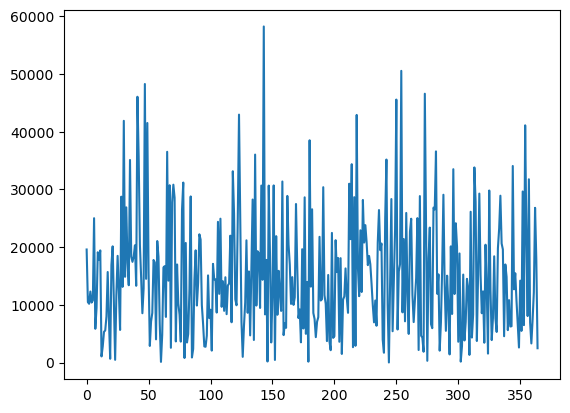

In [11]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(cdf["cost"])

In [26]:
# Monte Carlo
years = 100000
price_per_gb = 0.15214
async def generate_sample_sum():
    rows = np.round(gen_data(mu, 50, days), 0)*1e9
    size_kb = gen_data(1, 0.5, days)
    cdf = cudf.DataFrame({"rows": rows, "size": size_kb})
    cdf["total_size_gb"] = np.round((cdf["rows"] * cdf["size"])/1024/1024)
    cdf["cost"] = cdf["total_size_gb"] * price_per_gb
    return cdf["cost"].sum()

In [27]:
estimates = await asyncio.gather(*[generate_sample_sum() for _ in range(years)])

(array([1.23711830e-08, 2.06186384e-08, 4.12372767e-08, 1.01031328e-07,
        1.48454196e-07, 3.31960078e-07, 4.43300725e-07, 6.24744743e-07,
        9.38148046e-07, 1.14433443e-06, 1.45361400e-06, 1.80619272e-06,
        1.94639946e-06, 1.93609014e-06, 1.81650204e-06, 1.77320290e-06,
        1.57938770e-06, 1.35052081e-06, 1.00618955e-06, 7.62889620e-07,
        5.83507466e-07, 3.42269397e-07, 2.10310111e-07, 9.27838727e-08,
        7.21652343e-08, 4.12372767e-08, 2.06186384e-08, 2.06186384e-09,
        1.23711830e-08, 4.12372767e-09]),
 array([4720777.31524   , 4769277.12314267, 4817776.93104533,
        4866276.738948  , 4914776.54685067, 4963276.35475333,
        5011776.162656  , 5060275.97055867, 5108775.77846133,
        5157275.586364  , 5205775.39426667, 5254275.20216933,
        5302775.010072  , 5351274.81797467, 5399774.62587733,
        5448274.43378   , 5496774.24168267, 5545274.04958533,
        5593773.857488  , 5642273.66539067, 5690773.47329333,
        5739273.2811

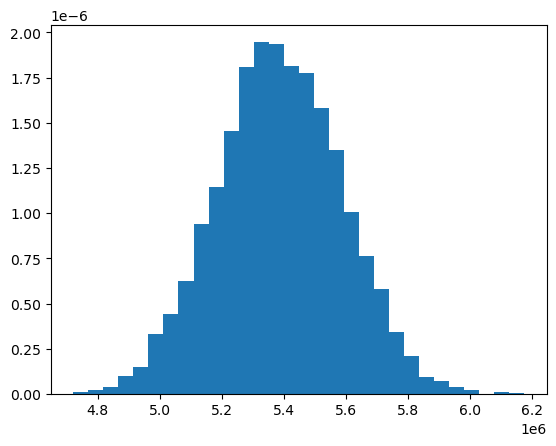

In [25]:
plt.hist(estimates, 30, density=True)